In [1]:
import torch 
import os
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch.optim as optim
import random
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [63]:

ngf = 64
nc = 3

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Conv2d(3, ngf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.Conv2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.Conv2d( ngf * 4, ngf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (nc) x 64 x 64
        )
        self.disp = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.Conv2d( ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )
        self.nor = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.Conv2d( ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, 3, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )
        self.rough = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.Conv2d( ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, 1, 1, 1, 1, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        common = self.main(input)
        disp = self.disp(common)
        nor = self.nor(common)
        rough = self.rough(common)
        return [disp, nor, rough]

In [64]:
g = Generator()
x = torch.rand(2,3,32,32)
o,o1,o2 = g(x)
o.shape

torch.Size([2, 1, 32, 32])

In [57]:
# Size of feature maps in discriminator
ndf = 64
nc = 3

class Discriminator(nn.Module):
    def __init__(self,nc):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [58]:
d = Discriminator(1)
x = torch.rand(32,3,256,256)
o = d(x)
o.size()

RuntimeError: Given groups=1, weight of size 64 1 4 4, expected input[32, 3, 256, 256] to have 1 channels, but got 3 channels instead

In [44]:
class TextureDataset(Dataset):
    def __init__(self, diff_dir, disp_dir, nor_dir, rough_dir,transform=None):
        self.diff = diff_dir
        self.disp = disp_dir
        self.nor = nor_dir
        self.rough= rough_dir
        self.transform = transform
    def __len__(self):
        return len(os.listdir(self.diff))
    def __getitem__(self,idx):
        img_name = os.listdir(self.diff)[idx][:-11]
        diff_img = Image.open(self.diff+"/"+img_name+"diff_1k.jpg").convert('RGB')
        disp_img = Image.open(self.disp+"/"+img_name+"disp_1k.jpg").convert('L')
        nor_img = Image.open(self.nor+"/"+img_name+"nor_1k.jpg")
        rough_img = Image.open(self.rough+"/"+img_name+"rough_1k.jpg").convert('L')
        img_list = [diff_img, disp_img, nor_img, rough_img]
        seed = np.random.randint(2147483647)

        if self.transform is not None:
            for i, img in enumerate(img_list):
                random.seed(seed)
                torch.manual_seed(seed)
                img_list[i] = self.transform(img)

        return {"diff": img_list[0], "disp": img_list[1], "nor": img_list[2], "rough":img_list[3]}

data_transform = transforms.Compose([
        transforms.RandomCrop(900),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
    ])
diff_dir = "./Data/diff"
disp_dir = "./Data/disp"
nor_dir = "./Data/nor"
rough_dir = "./Data/rough"
dataset = TextureDataset(diff_dir, disp_dir, nor_dir, rough_dir, transform = data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [65]:
device = torch.device("cuda")

netG = Generator().to(device)
netG.apply(weights_init)
netD_nor = Discriminator(3).to(device)
netD_disp = Discriminator(1).to(device)
netD_rough = Discriminator(1).to(device)
netD_nor.apply(weights_init)
netD_disp.apply(weights_init)
netD_rough.apply(weights_init)
netDs = [netD_disp, netD_nor, netD_rough]

In [66]:
criterion = nn.BCELoss()

lr = 0.0002
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD_disp = optim.Adam(netD_disp.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD_nor = optim.Adam(netD_nor.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD_rough = optim.Adam(netD_rough.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizers = [optimizerD_disp, optimizerD_nor, optimizerD_rough]

In [68]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        for j in range(3):
            dataD = [data["disp"],data["nor"],data["rough"]]
            netD = netDs[j]
            optimizerD = optimizers[j]
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = dataD[j].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = data["diff"].to(device)
            # Generate fake image batch with G
            fake = netG(noise)
            fake = fake[j]
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(train_dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
                with torch.no_grad():
                    data = next(iter(test_dataloader))
                    fake = netG(data["diff"].to(device))[j].detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

Starting Training Loop...
[0/100][0/5]	Loss_D: 8.3200	Loss_G: 0.9748	D(x): 0.9374	D(G(z)): 0.9821 / 0.5271
[0/100][0/5]	Loss_D: 1.0066	Loss_G: 4.6160	D(x): 0.6789	D(G(z)): 0.2624 / 0.0165
[0/100][0/5]	Loss_D: 4.7133	Loss_G: 5.8647	D(x): 1.0000	D(G(z)): 0.9801 / 0.0150
[1/100][0/5]	Loss_D: 1.4268	Loss_G: 0.8949	D(x): 0.4437	D(G(z)): 0.3991 / 0.5392
[1/100][0/5]	Loss_D: 0.2013	Loss_G: 3.7187	D(x): 0.9209	D(G(z)): 0.1034 / 0.0285
[1/100][0/5]	Loss_D: 0.0781	Loss_G: 5.5251	D(x): 0.9910	D(G(z)): 0.0649 / 0.0048
[2/100][0/5]	Loss_D: 1.3011	Loss_G: 1.3653	D(x): 0.6327	D(G(z)): 0.5179 / 0.2743
[2/100][0/5]	Loss_D: 0.3030	Loss_G: 1.5893	D(x): 0.8188	D(G(z)): 0.0248 / 0.2419
[2/100][0/5]	Loss_D: 0.0138	Loss_G: 5.6974	D(x): 0.9916	D(G(z)): 0.0052 / 0.0047
[3/100][0/5]	Loss_D: 1.1385	Loss_G: 0.8037	D(x): 0.4179	D(G(z)): 0.2200 / 0.5022
[3/100][0/5]	Loss_D: 4.0842	Loss_G: 0.3491	D(x): 0.0288	D(G(z)): 0.0119 / 0.7189
[3/100][0/5]	Loss_D: 0.0093	Loss_G: 6.1889	D(x): 0.9952	D(G(z)): 0.0044 / 0.0028
[4

[34/100][0/5]	Loss_D: 1.9823	Loss_G: 1.7120	D(x): 0.7819	D(G(z)): 0.7511 / 0.2071
[34/100][0/5]	Loss_D: 0.9792	Loss_G: 2.3494	D(x): 0.4361	D(G(z)): 0.0675 / 0.1147
[34/100][0/5]	Loss_D: 0.0006	Loss_G: 8.0090	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004
[35/100][0/5]	Loss_D: 1.1232	Loss_G: 1.0540	D(x): 0.4078	D(G(z)): 0.1656 / 0.3783
[35/100][0/5]	Loss_D: 0.9755	Loss_G: 0.7737	D(x): 0.7001	D(G(z)): 0.3656 / 0.5011
[35/100][0/5]	Loss_D: 0.0007	Loss_G: 7.9906	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[36/100][0/5]	Loss_D: 0.8345	Loss_G: 2.0190	D(x): 0.6847	D(G(z)): 0.3104 / 0.1598
[36/100][0/5]	Loss_D: 0.7073	Loss_G: 2.1144	D(x): 0.8570	D(G(z)): 0.4050 / 0.1403
[36/100][0/5]	Loss_D: 0.0010	Loss_G: 8.2076	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005
[37/100][0/5]	Loss_D: 0.9370	Loss_G: 1.8832	D(x): 0.6145	D(G(z)): 0.1574 / 0.2033
[37/100][0/5]	Loss_D: 0.7792	Loss_G: 1.6617	D(x): 0.7248	D(G(z)): 0.3360 / 0.2021
[37/100][0/5]	Loss_D: 0.0005	Loss_G: 8.4895	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[38/100][0/5]	Lo

[68/100][0/5]	Loss_D: 0.6625	Loss_G: 2.6762	D(x): 0.6389	D(G(z)): 0.1076 / 0.0909
[68/100][0/5]	Loss_D: 1.3388	Loss_G: 1.5360	D(x): 0.6842	D(G(z)): 0.5563 / 0.2617
[68/100][0/5]	Loss_D: 0.0001	Loss_G: 10.0189	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[69/100][0/5]	Loss_D: 1.1988	Loss_G: 1.0889	D(x): 0.9163	D(G(z)): 0.6095 / 0.4012
[69/100][0/5]	Loss_D: 1.9461	Loss_G: 3.3336	D(x): 0.1795	D(G(z)): 0.0102 / 0.0545
[69/100][0/5]	Loss_D: 0.0001	Loss_G: 9.8870	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[70/100][0/5]	Loss_D: 0.8754	Loss_G: 2.1395	D(x): 0.4863	D(G(z)): 0.0769 / 0.2016
[70/100][0/5]	Loss_D: 1.5570	Loss_G: 1.6942	D(x): 0.8965	D(G(z)): 0.7215 / 0.2314
[70/100][0/5]	Loss_D: 0.0002	Loss_G: 9.5144	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[71/100][0/5]	Loss_D: 0.7454	Loss_G: 1.7895	D(x): 0.7138	D(G(z)): 0.2946 / 0.2382
[71/100][0/5]	Loss_D: 1.1413	Loss_G: 1.4360	D(x): 0.4575	D(G(z)): 0.2196 / 0.2930
[71/100][0/5]	Loss_D: 0.0001	Loss_G: 9.9302	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[72/100][0/5]	L

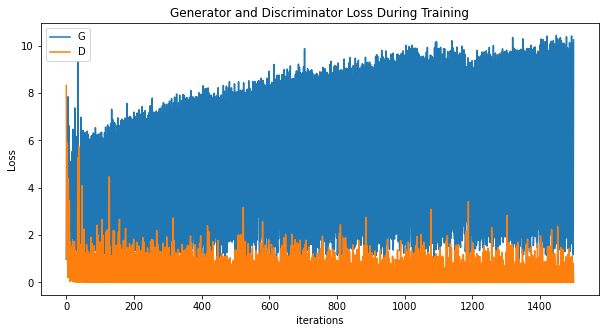

In [69]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

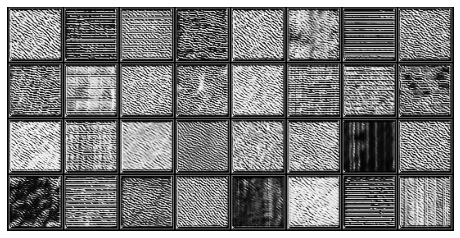

In [70]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

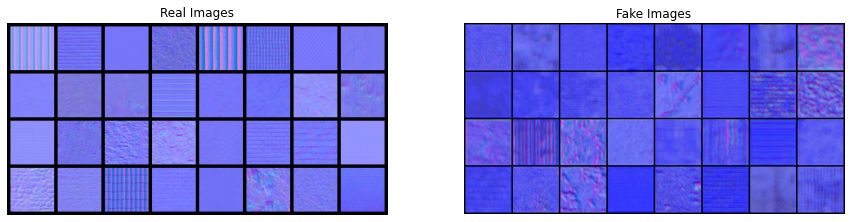

In [75]:
# Grab a batch of real images from the dataloader
real_batch= next(iter(test_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch["nor"].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-2],(1,2,0)))
plt.show()